In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from database.dataset import INBreast_Dataset
from mc_detection.hough_mc import HoughCalcificationDetection
from general_utils.metrics import circle_comparison, quick_circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show2, simple_im_show
from pathlib import Path
from tqdm import tqdm
import cv2


In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_size_mm=2.0,
    extract_patches=False,
    extract_patches_method='all',  # 'centered'
    patch_size=256,
    stride=256,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    partitions=['train'],
    return_indexes_in_mask=True)


In [4]:
dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 8,  'minRadius': 2, 'maxRadius': 20}

hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 10,  'minRadius': 2, 'maxRadius': 20}

back_ext_radius = 50

erosion_iter = 20
erosion_size = 5


hd = HoughCalcificationDetection(dehazing_params, back_ext_radius,
                                 Path.cwd().parent / 'data/hough_img',    # "/media/vzalevskyi/DATA/ProjectsData/calc-det/no_dehaizing",
                                 hough1_params, hough2_params,
                                 erosion_iter=erosion_iter,
                                 erosion_size=erosion_size)


In [5]:
h1_res = []
h2_res = []

for idx in tqdm(range(len(db))):
    mask = db[idx]['lesion_mask']
    image = db[idx]['img']
    image_id = db.df.iloc[idx].img_id
    true_bboxes = db[idx]['lesion_bboxes']

    h1_circles, h2_circles = hd.detect(
        image, image_id, load_processed_images=True, hough2=True)

    
    TP, FP, FN = quick_circle_comparison(h1_circles, mask)
    h1_res.append({'image_id':image_id, 'TP': TP, 'FP': FP, 'FN': FN})
    
    TP, FP, FN = quick_circle_comparison(h2_circles, mask)
    h2_res.append({'image_id': image_id, 'TP': TP, 'FP': FP, 'FN': FN})

100%|██████████| 165/165 [14:30<00:00,  5.27s/it]


In [10]:
h1_res_df = pd.DataFrame(h1_res).set_index('image_id')
h1_res_df['sensitivity'] =  h1_res_df.TP/(h1_res_df.TP + h1_res_df.FN)
h1_res_df['f1'] =  h1_res_df.TP/(h1_res_df.TP + 0.5*(h1_res_df.FN + h1_res_df.FP))

h2_res_df = pd.DataFrame(h2_res).set_index('image_id')
h2_res_df['sensitivity'] =  h2_res_df.TP/(h2_res_df.TP + h2_res_df.FN)
h2_res_df['f1'] =  h2_res_df.TP/(h2_res_df.TP + 0.5*(h2_res_df.FN + h2_res_df.FP))

merged_df = h1_res_df.join(h2_res_df, lsuffix='_h1', rsuffix='_h2')
merged_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,TP_h1,FP_h1,FN_h1,sensitivity_h1,f1_h1,TP_h2,FP_h2,FN_h2,sensitivity_h2,f1_h2
image_id,,,,,,,,,,
20586908,30,1452,10,0.750000,0.039422,20,695,20,0.500000,0.052980
20586934,52,1191,8,0.866667,0.079816,37,570,23,0.616667,0.110945
20586960,42,1626,1,0.976744,0.049094,31,619,12,0.720930,0.089466
20586986,14,1826,0,1.000000,0.015102,11,1059,3,0.785714,0.020295
20587148,3,612,0,1.000000,0.009709,3,279,0,1.000000,0.021053
...,...,...,...,...,...,...,...,...,...,...
30011507,17,477,5,0.772727,0.065891,9,125,13,0.409091,0.115385
30011530,9,872,5,0.642857,0.020112,7,276,7,0.500000,0.047138
30011553,8,888,4,0.666667,0.017621,5,259,7,0.416667,0.036232


<AxesSubplot:>

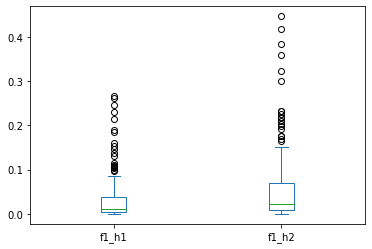

In [11]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

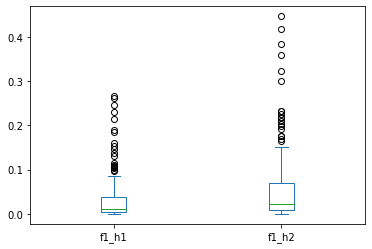

In [12]:
merged_df[['f1_h1', 'f1_h2']].plot.box()

<AxesSubplot:>

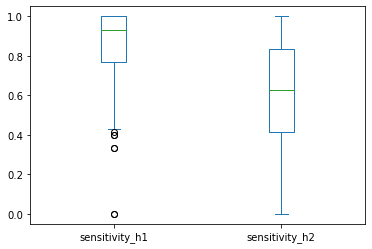

In [8]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<AxesSubplot:>

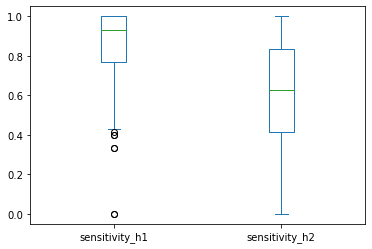

In [9]:
merged_df[['sensitivity_h1', 'sensitivity_h2']].plot.box()

<IPython.core.display.Javascript object>

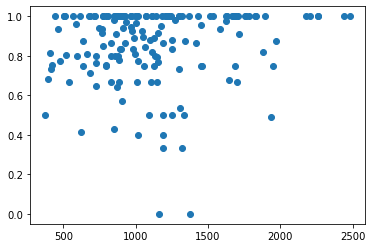

In [10]:
plt.scatter(h1_res_df.FP.values, h1_res_df.sensitivity.values)

In [11]:
h1_res_df.sensitivity.median()

0.9333333333333333

<AxesSubplot:ylabel='Frequency'>

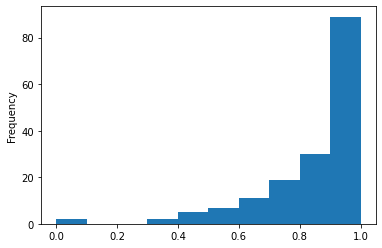

In [12]:
h1_res_df.sensitivity.plot.hist()

<AxesSubplot:ylabel='Frequency'>

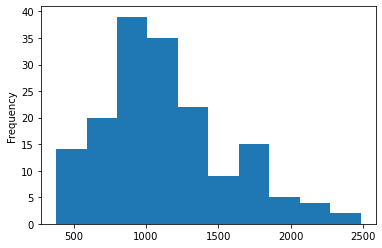

In [13]:
(h1_res_df.TP + h1_res_df.FP).plot.hist()

In [14]:
(h1_res_df.TP + h1_res_df.FP).mean()

1136.521212121212